# **Classificação das vítimas do naufrágio do Titanic usando PySpark**

Este notebook utiliza o PySpark para a reolução do tradicional desafio de se prever, usando Machine Learning,negrito quais passageiros que sobreviveram após embarcarem na viagem inaugural do dito "inafundável" navio chamado Titanic.

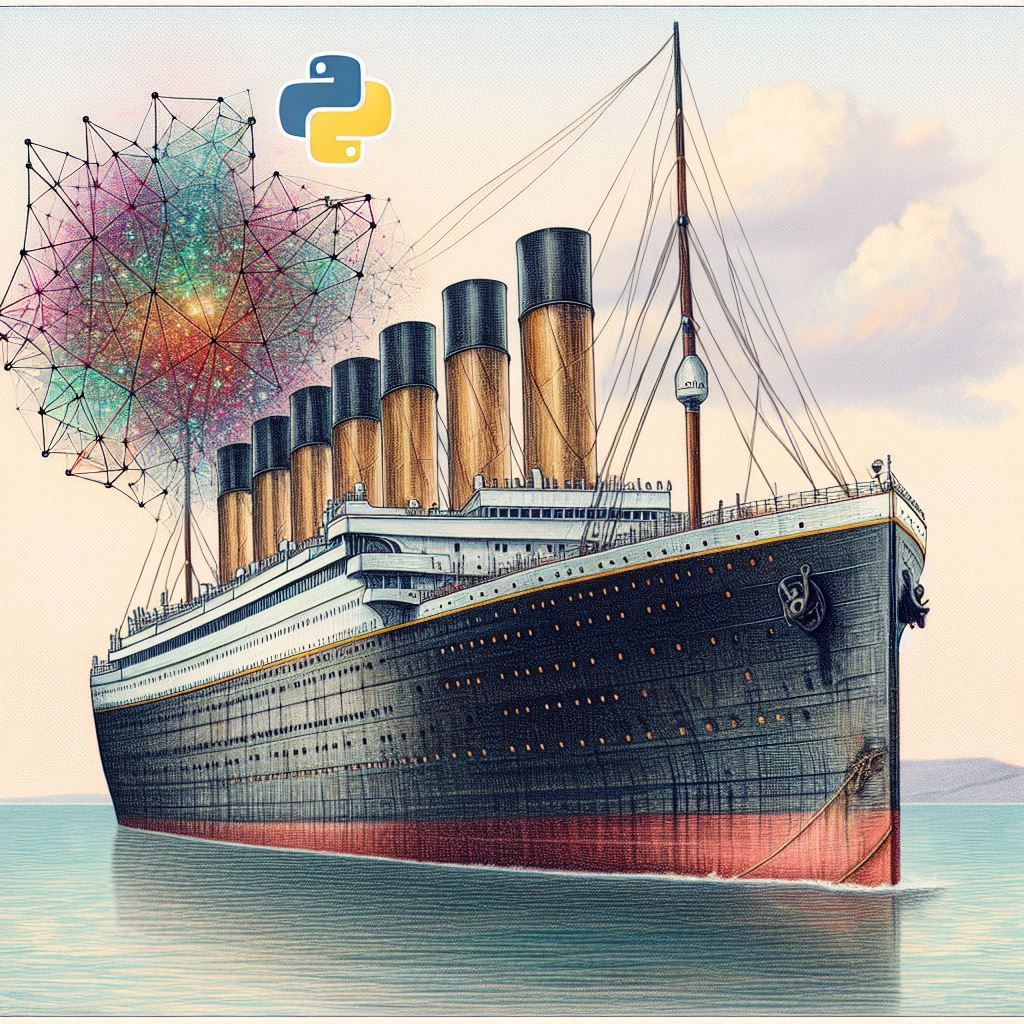

Para contextualizar, seguem informações do desastre histórico:

A embarcação partiu em sua viagem inaugural de Southampton com destino a Nova Iorque em 10 de abril de 1912, no caminho passando em Cherbourg-Octeville, na França, e por Queenstown, na Irlanda. Colidiu com um iceberg na proa dianteira do lado direito às 23h40 de 14 de abril, naufragando na madrugada do dia seguinte, com mais de 1 500 pessoas a bordo, sendo um dos maiores desastres marítimos em tempos de paz de toda a história. Seu naufrágio destacou vários pontos fracos do projeto, deficiências nos procedimentos de evacuação de emergência e falhas nas regulamentações marítimas.

Dez em cada dez cientistas de dados conhecem este dataset visto que é explorado em diversos livros como exemplo didático e utilizado em uma competição para iniciantes no Kaggle.



In [1]:
import os
os.environ["JAVA_HOME"] = "C:\\jdk-22.0.2"
os.environ["SPARK_HOME"] = "C:\\spark-3.5.2-bin-hadoop3\\spark-3.5.2-bin-hadoop3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_PYTHON"] = "python"

In [2]:
# Obtenção dos dados
import urllib.request
from zipfile import ZipFile


DOWNLOAD_URL = "https://github.com/alexvaroz/data_science_alem_do_basico/raw/master/titanic.zip"
DATASET_PATH = "C:\\01-FaculdadeSemestreAtual\\Processamento_de_Dados_Massivos\\dataset_titanic"

# Função para obtenção dos dados
def fetch_data(download_url=DOWNLOAD_URL, dataset_path=DATASET_PATH):
    os.makedirs(dataset_path, exist_ok=True) # cria o diretório
    zip_path = os.path.join(dataset_path, "titanic.zip")
    urllib.request.urlretrieve(download_url, zip_path)
    files = ZipFile(zip_path,'r')
    files.extractall()
    files.close()

# fetch_data()

Para utilizar as bibliotecas dos modelos de machine learning do PySpark, serão explorados os recursos do módulo [Spark MLLib](https://spark.apache.org/docs/latest/ml-guide.html).

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit, regexp_extract
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np


spark = SparkSession.builder.appName('Pyspark_Titanic').getOrCreate()

In [4]:
spark

In [5]:
df = spark.read.csv('C:\\01-FaculdadeSemestreAtual\\Processamento_de_Dados_Massivos\\dataset_titanic\\train.csv',header = 'True',inferSchema='True')

In [6]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



O primeiro passo é verificar a completude dos atributos:

In [7]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [8]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [9]:
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [10]:
# Eliminar o atributo "Cabin"
df = df.drop("Cabin")

In [11]:
df.limit(100).toPandas().sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,C
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,S
87,88,0,3,"Slocovski, Mr. Selman Francis",male,NaN,0,0,SOTON/OQ 392086,8.0500,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,C
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,S


Para completar os dados faltantes de do campo "Age", a estratégia é utilizar os títulos presentes nos nomes dos passageiros.

Extrai-se os títulos de cada nome e tira a média de idade. Então completa-se os faltantes usando a média de acordo com o título (`Title`).

Para a extração do título se utiliza expressões regulares.

In [12]:
df = df.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.", 1))

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\guiro\AppData\Local\Temp\ipykernel_21308\1253779130.py:1: SyntaxWarning: invalid escape sequence '\.'
  df = df.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.", 1))


In [13]:
df.limit(100).toPandas().sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,S,Miss
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,S,Master
22,23,1,3,"""McGowan, Miss. Anna """"Annie""""""",female,15.0,0,0,330923,8.0292,Q,Miss
90,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,S,Mr
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,S,Mrs


In [14]:
df.select('Title').distinct().show(17)

+--------+
|   Title|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



In [15]:
df.groupby('Title').count().show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|    Miss|  182|
|Countess|    1|
|     Col|    2|
|     Rev|    6|
|    Lady|    1|
|  Master|   40|
|     Mme|    1|
|    Capt|    1|
|      Mr|  517|
|      Dr|    7|
|     Mrs|  125|
|     Sir|    1|
|Jonkheer|    1|
|    Mlle|    2|
|   Major|    2|
|      Ms|    1|
+--------+-----+



Padronizando os títulos em Mr, Master, Miss, Mrs e Other (para os restantes)

In [16]:
df = df.replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr', 'Mrs', 'Mrs','Other','Other','Other','Mr','Mr','Mr'])

# Verificando a média de idade pelos títulos definidos
df.groupby('Title').avg('Age').collect()

[Row(Title='Miss', avg(Age)=21.86),
 Row(Title='Other', avg(Age)=45.888888888888886),
 Row(Title='Master', avg(Age)=4.574166666666667),
 Row(Title='Mr', avg(Age)=32.73960880195599),
 Row(Title='Mrs', avg(Age)=35.981818181818184)]

In [17]:
# Imputando os dados  de acordo com os títulos

df = df.withColumn("Age",when((df["Title"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Title"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Title"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Title"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Title"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

Outro atributo com dados faltantes é o `Embarked`

In [18]:
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [19]:
# Como o número é bem reduzido, pode-se optar por imputar o valor mais frequente.
df = df.na.fill({"Embarked" : 'S'})

In [20]:
# Voltando a checar os dados faltantes
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-----+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Title|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-----+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|    0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-----+



Continuando a etapa de *feature engineering*, hora de tratar os atributos `SibSp` e `Parch` que referem-se, respectivamente, a número de irmãos ou cônjuges a bordo e número de pais ou filhos a bordo.

Para isso, será criado um novo atributo `Family_Size`, somando os valores das duas colunas.

In [21]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch'))

In [20]:
df.select('Family_Size').distinct().show()

+-----------+
|Family_Size|
+-----------+
|          1|
|          6|
|          3|
|          5|
|          4|
|          7|
|         10|
|          2|
|          0|
+-----------+



Pode ser criado um novo atributo `Alone` para indicar que o passageiro não tem familiares junto.

In [21]:
df = df.withColumn('Alone',lit(0))
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

Chega a etapa de transformar as variávies categóricas em numéricas, de modo que possam ser utilizadas no modelo.

Para isso, se utiliza o módulo `One Hot Encoder`.

In [22]:
# Definir as colunas categóricas se deseja codificar
categorical_columns = ["Sex", "Embarked", "Title"]

# Criar os indexadores
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]

# Criar os OneHotEncoders
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_onehot") for column in ["Embarked", "Title"]]

# Criar um pipeline que aplica primeiro os indexadores e depois os encoders
pipeline = Pipeline(stages=indexers + encoders)

# Ajustar e transformar o DataFrame com o pipeline
df_encoded = pipeline.fit(df).transform(df)

# Mostrar o resultado
df_encoded.show()


+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+------+-----------+-----+---------+--------------+-----------+---------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked| Title|Family_Size|Alone|Sex_index|Embarked_index|Title_index|Embarked_onehot| Title_onehot|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+------+-----------+-----+---------+--------------+-----------+---------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|    Mr|          1|    0|      0.0|           0.0|        0.0|  (2,[0],[1.0])|(4,[0],[1.0])|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|   Mrs|          1|    0|      1.0|           1.0|        2.0|  (2,[1],[1.0])|(4,[2],[1.

In [23]:
df_encoded.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Family_Size,Alone,Sex_index,Embarked_index,Title_index,Embarked_onehot,Title_onehot
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0)"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)"


In [24]:
# Agora, são elimindas as colunas que não são úteis
df_encoded = df_encoded.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Title", "Embarked_index","Title_index")

# Antes de modelar, todas as colunas são colocadas em único vetor
feature = VectorAssembler(inputCols = df_encoded.columns[1:],outputCol="features")
feature_vector=feature.transform(df_encoded)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_onehot,Title_onehot,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 1.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0)","(1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 1...."


In [25]:
# Seleciona as colunas usadas no treinamento
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

O primeiro algoritmo a ser treinado será o de Regressão Logística:

In [26]:
lr = LogisticRegression(labelCol="Survived")

model = lr.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='f1').evaluate(model_predictions))

Accuracy:  0.8715596330275229
Precision:  0.8709317593721264
Recall:  0.871559633027523
F1-Score:  0.8711668854265138


In [27]:
# Ajustando os hiperparâmetros
lr = LogisticRegression(labelCol="Survived")

# Definindo as faixas dos hiperparâmtros para o Grid Search
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

from pyspark.ml.tuning import CrossValidator

# Etapa de cross-validation usando 5 folds
cv = CrossValidator( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,numFolds=5)
model = cv.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='f1').evaluate(model_predictions))

Accuracy:  0.8623853211009175
Precision:  0.8612689759179728
Recall:  0.8623853211009175
F1-Score:  0.861512799127478


Random Forest:

In [28]:
rf = RandomForestClassifier(labelCol='Survived')

model = rf.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='f1').evaluate(model_predictions))

Accuracy:  0.8623853211009175
Precision:  0.8611037127087557
Recall:  0.8623853211009174
F1-Score:  0.8610293206050086


In [ ]:
# Ajustando os hiperparâmetros (demora mais...)
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
    trainRatio=0.8
)

model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='Survived', metricName='f1').evaluate(model_predictions))

In [ ]:
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                             .addGrid(gbt.maxDepth, [5, 10, 20]) \
                             .addGrid(gbt.maxBins, [20, 32, 50]) \
                             .addGrid(gbt.maxIter, [10, 20, 30]) \
                             .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                             .build()

cv = CrossValidator( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,numFolds=5)
model = cv.fit(train_df)
model_predictions= model.transform(test_df)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))